In [15]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
import tensorflow as tf
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## import drive and GPU

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [5]:
test_path ="/content/drive/MyDrive/ML/OCT_preprocessed/Test"
train_path ="/content/drive/MyDrive/ML/OCT_preprocessed/Train"

image_size=(128,128,3)

In [6]:
category_list = os.listdir(train_path)
category_list

['DME', 'Normal']

In [7]:
number_of_classes= len(category_list)

# get the images and vertical projection

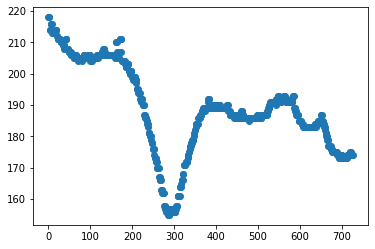

In [8]:
def get_vertical_projection(img_dir):
  img = cv2.imread(img_dir)
  ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  X_data = []
  Y_data = []
  x,y,c = bw_img.shape
  for Y in range(y):
    for X in range(x):
        if bw_img[X][Y][0] == 255:
              X_data.append(Y)
              Y_data.append(x - X)
              break
  return X_data, Y_data

X_data,Y_data = get_vertical_projection('/content/drive/MyDrive/ML/OCT_preprocessed/Train/Normal/3.jpeg')
plt.scatter(X_data, Y_data)

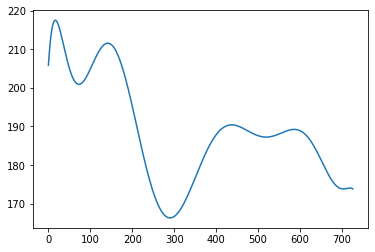

In [9]:
poly = np.polyfit(X_data,Y_data , deg=10)
plt.plot(np.polyval(poly, X_data), label='fit')

In [10]:
def get_image_list(path, categories):
    images=[]
    class_num=[]
    x_proj = []
    y_proj = []
    projection_data = []
    poly_coeff = []
    for cat in (categories):
        img_list = os.listdir(path +'/'+cat)
        for img in tqdm(img_list):
            im = cv2.imread(path +'/'+cat+"/"+img)
            im = cv2.resize(im, (image_size[0], image_size[1]))
            images.append(im)
            class_num.append(categories.index(cat))

            X_data,Y_data = get_vertical_projection(path +'/'+cat+"/"+img)
            poly = np.polyfit(X_data, Y_data , deg=10)
            poly_coeff.append(np.array(poly))

            # x_proj.append(X_data)
            # y_proj.append(Y_data)
            
            # projection_data.append([X_data, Y_data])
    # return images, class_num, x_proj, y_proj, projection_data
    return images, class_num, poly_coeff

In [12]:
# train_img_X, train_img_Y, x_proj_train, y_proj_train, projection_train = get_image_list(train_path, ['Normal',"DME"])
# val_img_X, val_img_Y, x_proj_val, y_proj_val, projection_test = get_image_list(test_path, ['Normal',"DME"])
train_img_X, train_img_Y, poly_coeff_train = get_image_list(train_path, ['Normal',"DME"])
val_img_X, val_img_Y, poly_coeff_val = get_image_list(test_path, ['Normal',"DME"])

100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


In [134]:
print(len(train_img_X), len(train_img_Y), len(val_img_X), len(val_img_Y), len(poly_coeff_train), len(poly_coeff_val)  )

2229 2229 84 84 2229 84


In [203]:
columns = np.arange(0,11,1)
df = pd.DataFrame(poly_coeff_train, columns=columns)
df['target'] = train_img_Y
df = shuffle(df)

In [204]:
X = df.iloc[:,0:11]  #independent columns
y = df.iloc[:,-1] 

# Normalized features

In [205]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [206]:
new_df = pd.DataFrame(X, columns=columns)
new_df['target'] = y
new_df = shuffle(new_df)
new_df

,0,1,2,3,4,5,6,7,8,9,10,target
1824,2.911828e-18,0.152878,0.808106,0.240794,0.706564,0.343017,0.623919,0.315099,0.721759,0.268326,0.352881,1
1797,2.906389e-18,0.156979,0.798079,0.264612,0.651629,0.465564,0.359613,0.676683,0.415832,0.479689,0.388330,1
1941,2.910490e-18,0.153886,0.805644,0.246628,0.693184,0.372519,0.561725,0.396832,0.656461,0.314060,0.968949,1
1989,2.913349e-18,0.152011,0.809622,0.238476,0.709241,0.342442,0.614718,0.339825,0.693384,0.295243,0.243849,1
568,2.911579e-18,0.153106,0.807473,0.242433,0.702591,0.352015,0.604906,0.340025,0.700458,0.285140,0.363382,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.913878e-18,0.151527,0.811018,0.234632,0.719440,0.316368,0.678688,0.242948,0.777947,0.238864,0.303129,0
1912,2.913885e-18,0.151502,0.811104,0.234412,0.719861,0.315923,0.678025,0.245428,0.779005,0.239229,0.326964,1
1417,2.910203e-18,0.154072,0.805266,0.247330,0.692054,0.373899,0.560982,0.395720,0.660936,0.283369,0.360496,1
1285,2.912528e-18,0.152437,0.809001,0.239044,0.709868,0.337002,0.634476,0.303673,0.728893,0.270345,0.269250,1


# Get test set 
- current test set used as validation set

In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [158]:
x_val = np.array(poly_coeff_val)
y_val = np.array(val_img_Y)

In [159]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(1783, 11) (1783,)
(446, 11) (446,)
(84, 11) (84,)


In [160]:
# y_train = to_categorical(y_train,number_of_classes)
# y_test = to_categorical(y_test,number_of_classes)
# y_val = to_categorical(y_val,number_of_classes)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(x_val.shape, y_val.shape)

# Model definition

In [161]:
#Load sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#Learning curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from IPython.display import display_html
import warnings

# for inline plots
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 2)

In [162]:
classes = ['Normal',"DME"]
cv = ShuffleSplit(n_splits = 100, test_size = 0.25, random_state = 0)
train_size = np.linspace(.1, 1.0, 15)
cmap = 'viridis'

In [163]:
    
# Learning curve
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = 4, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    ax1 = Confuse(y, y_pred, classes)
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std )

def ApplyModel(X, y, model):
    
    model.fit(X, y)
    y_pred  = model.predict(X)

    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
 
    Error   = 1 - Accuracy
    
    precision = precision_score(y_train, y_pred) * 100
    recall = recall_score(y_train, y_pred) * 100
    f1score = f1_score(y_train, y_pred) * 100
    
    return (model, y_pred, Accuracy, Error, precision, recall, f1score)  
    
def Confuse(y, y_pred, classes):
    cnf_matrix = confusion_matrix(y, y_pred)
    
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    c_train = pd.DataFrame(cnf_matrix, index = classes, columns = classes)  

    ax = sns.heatmap(c_train, annot = True, cmap = cmap, square = True, cbar = False, 
                          fmt = '.2f', annot_kws = {"size": 20})
    return(ax, c_train)

def PrintResults(model, X, y, title):
    
    model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    _, Score_mean, Score_std = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    print("Precision: %.2f %%"%(precision))
    print("Recall: %.2f %%"%(recall))
    print('f1-score: %.2f %%'%(f1score))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std, 
                       'Precision': precision, 
                       'Recall': recall, 
                       'F1-Score': f1score}, index = [0])
    return (model, Summary)

Scoring Accuracy: 58.00 %
Scoring Mean: 57.29 %
Scoring Standard Deviation: 2.6565 %
Precision: 59.06 %
Recall: 66.56 %
f1-score: 62.59 %


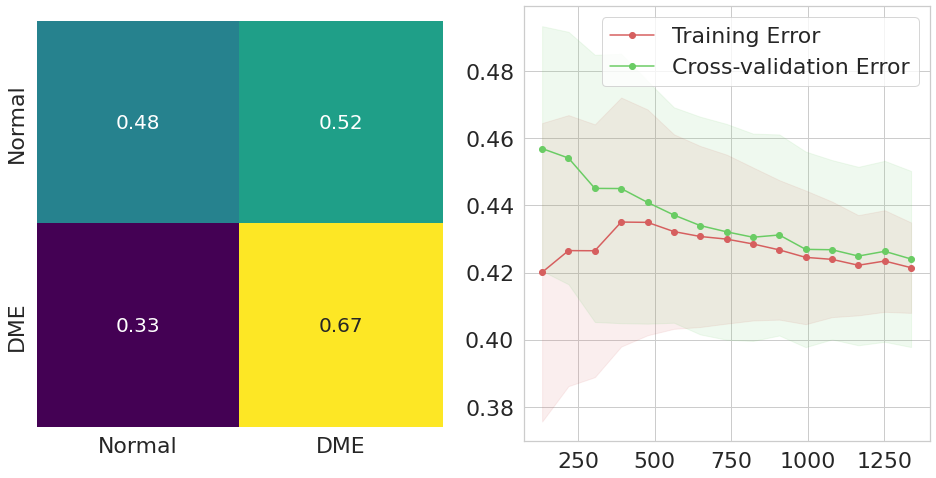

In [164]:
model = LogisticRegression()
model, Summary_LR = PrintResults(model, x_train, y_train, 'Logistic Regression')

y_train_LR = pd.Series(model.predict(x_train), name = "LR")
y_test_LR = pd.Series(model.predict(x_test), name = "LR")

# importance = model.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))


Scoring Accuracy: 55.00 %
Scoring Mean: 55.43 %
Scoring Standard Deviation: 4.1928 %
Precision: 78.38 %
Recall: 27.62 %
f1-score: 40.85 %


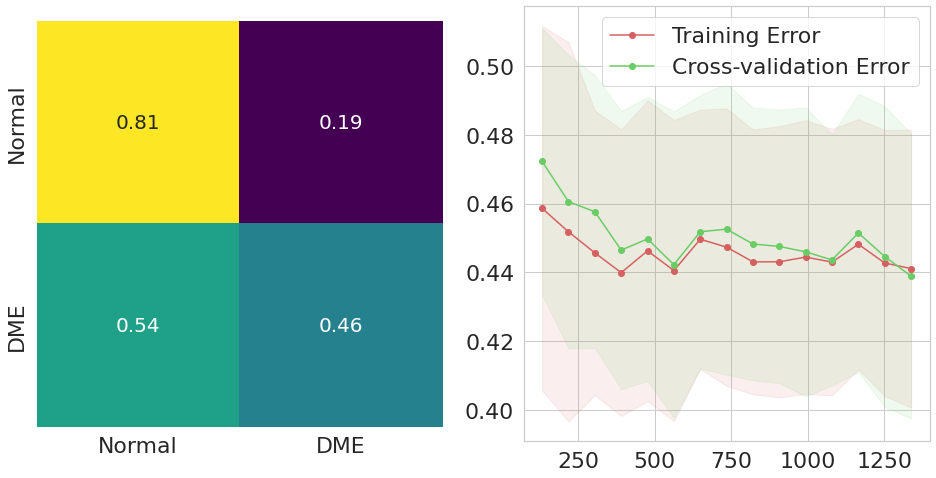

In [165]:
# stochastic gradient descent (SGD) learning
model = linear_model.SGDClassifier(max_iter = 200, tol = None)
model,Summary_SGD = PrintResults(model, x_train, y_train, 'SGD')
y_train_SGD = pd.Series(model.predict(x_train), name = "SGD")
y_test_SGD = pd.Series(model.predict(x_test), name = "SGD")

# importance = model.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

Scoring Accuracy: 75.00 %
Scoring Mean: 97.48 %
Scoring Standard Deviation: 0.6159 %
Precision: 97.78 %
Recall: 97.78 %
f1-score: 97.78 %


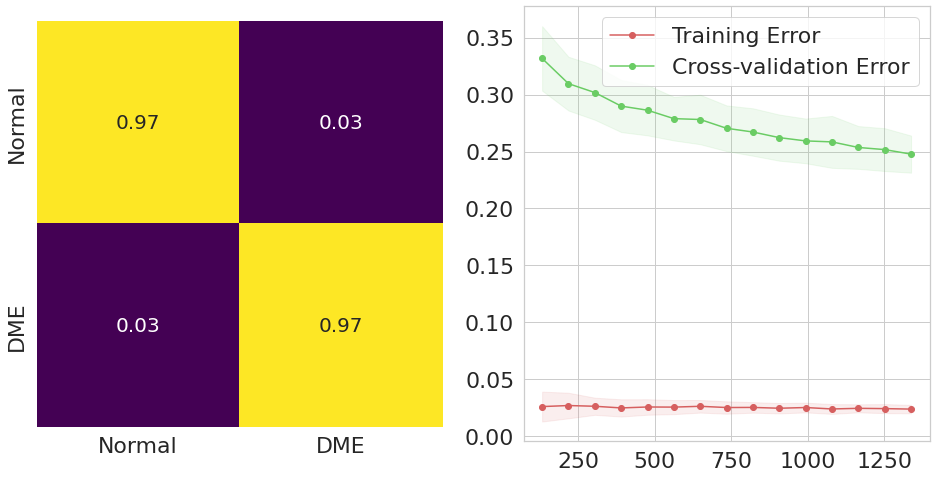

In [166]:
# Random Forest
model = RandomForestClassifier(n_estimators = 10)
model,Summary_RF = PrintResults(model, x_train,y_train, 'Random Forest')
y_train_RF = pd.Series(model.predict(x_train), name = "RF")
y_test_RF = pd.Series(model.predict(x_test), name = "RF")

# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

Scoring Accuracy: 65.00 %
Scoring Mean: 63.24 %
Scoring Standard Deviation: 2.0472 %
Precision: 80.69 %
Recall: 46.88 %
f1-score: 59.30 %


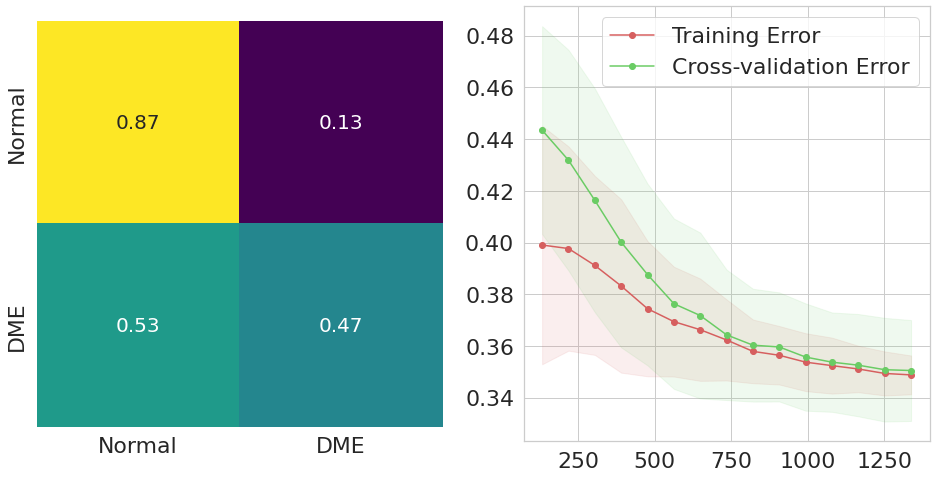

In [167]:
#SVM
model = SVC()
model,Summary_SVM = PrintResults(model, x_train, y_train, 'SVM')
y_train_SVM = pd.Series(model.predict(x_train), name = "SVM")
y_test_SVM = pd.Series(model.predict(x_test), name = "SVM")

Scoring Accuracy: 71.00 %
Scoring Mean: 82.77 %
Scoring Standard Deviation: 1.4471 %
Precision: 86.50 %
Recall: 82.75 %
f1-score: 84.59 %


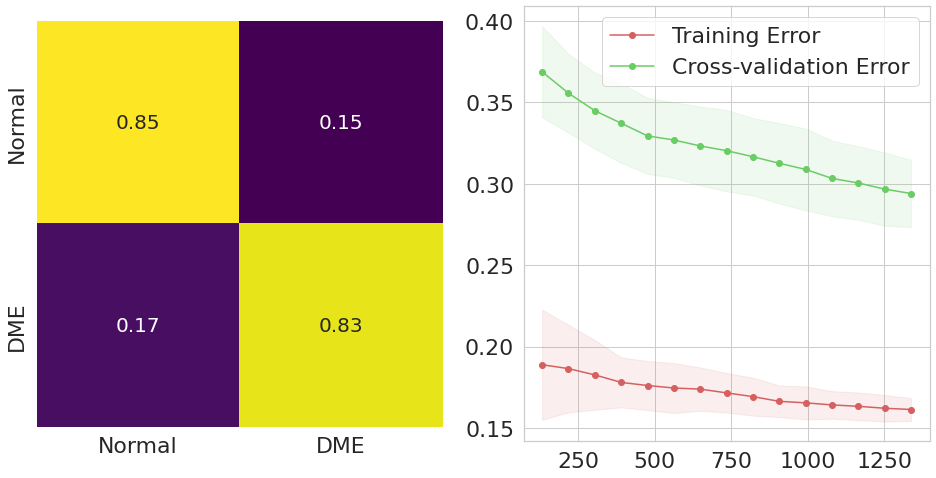

In [168]:
# KNN
model = KNeighborsClassifier(n_neighbors = 3)
model,Summary_KNN = PrintResults(model, x_train, y_train,'KNN')
y_train_KNN = pd.Series(model.predict(x_train), name = "KNN")
y_test_KNN = pd.Series(model.predict(x_test), name = "KNN")

Scoring Accuracy: 58.00 %
Scoring Mean: 60.88 %
Scoring Standard Deviation: 3.4243 %
Precision: 86.62 %
Recall: 24.66 %
f1-score: 38.39 %


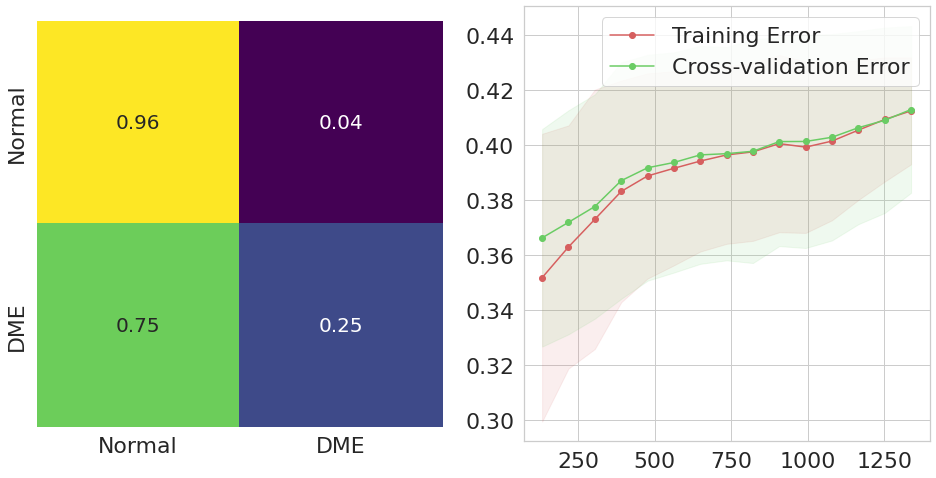

In [169]:
# Gaussian Naive Bayes
model = GaussianNB()
model,Summary_GNB = PrintResults(model, x_train, y_train, "GNB")
y_train_GNB = pd.Series(model.predict(x_train), name = "GNB")
y_test_GNB = pd.Series(model.predict(x_test), name = "GNB")

Scoring Accuracy: 51.00 %
Scoring Mean: 51.76 %
Scoring Standard Deviation: 3.0878 %
Precision: 78.81 %
Recall: 9.84 %
f1-score: 17.50 %


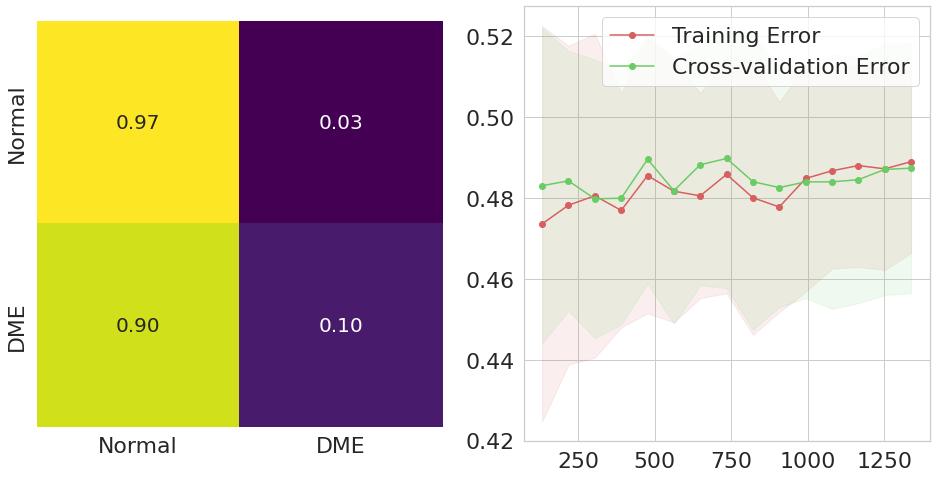

In [170]:
# Perceptron
model = Perceptron(max_iter = 5)
model,Summary_MLP = PrintResults(model, x_train, y_train, 'MLP')
y_train_MLP = pd.Series(model.predict(x_train), name = "MLP")
y_test_MLP = pd.Series(model.predict(x_test), name = "MLP")

Scoring Accuracy: 59.00 %
Scoring Mean: 59.05 %
Scoring Standard Deviation: 2.6719 %
Precision: 60.71 %
Recall: 66.88 %
f1-score: 63.65 %


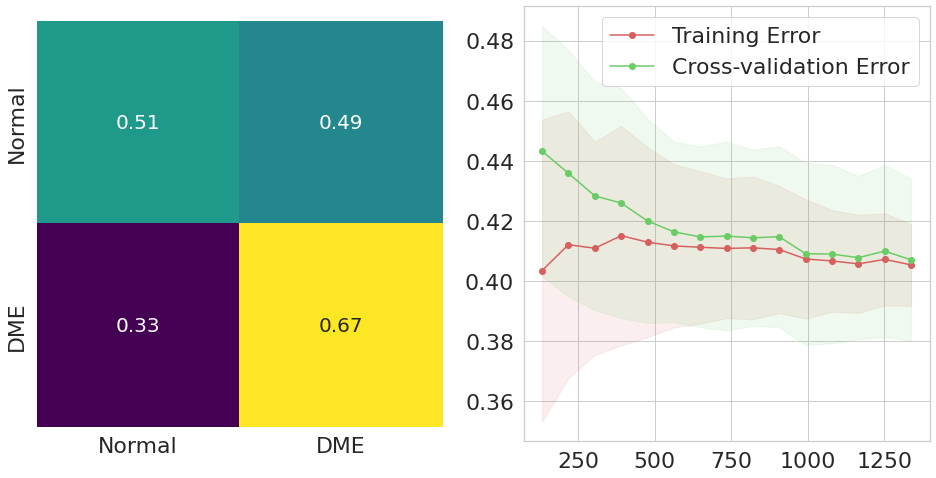

In [171]:
# Linear SVC
model = LinearSVC()
model,Summary_LSVM = PrintResults(model, x_train, y_train,"LSVM")
y_train_LSVM = pd.Series(model.predict(x_train), name = "LSVM")
y_test_LSVM = pd.Series(model.predict(x_test), name = "LSVM")

Scoring Accuracy: 72.00 %
Scoring Mean: 99.24 %
Scoring Standard Deviation: 0.2705 %
Precision: 98.44 %
Recall: 100.00 %
f1-score: 99.21 %


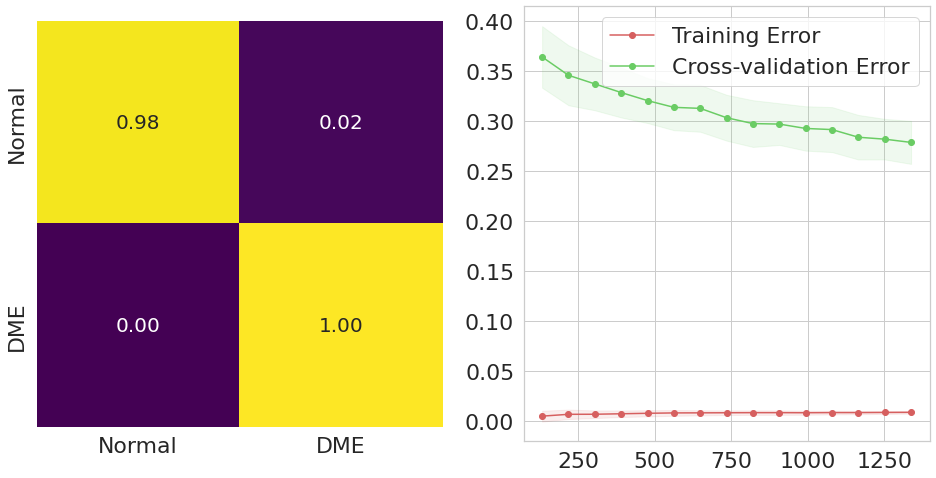

In [172]:
# Decision Tree
model = DecisionTreeClassifier()
model,Summary_DT = PrintResults(model, x_train, y_train, 'DT')
y_train_DT = pd.Series(model.predict(x_train), name = "DT")
y_test_DT = pd.Series(model.predict(x_test), name = "DT")

# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

Scoring Accuracy: 74.00 %
Scoring Mean: 81.82 %
Scoring Standard Deviation: 1.4395 %
Precision: 85.15 %
Recall: 71.01 %
f1-score: 77.44 %


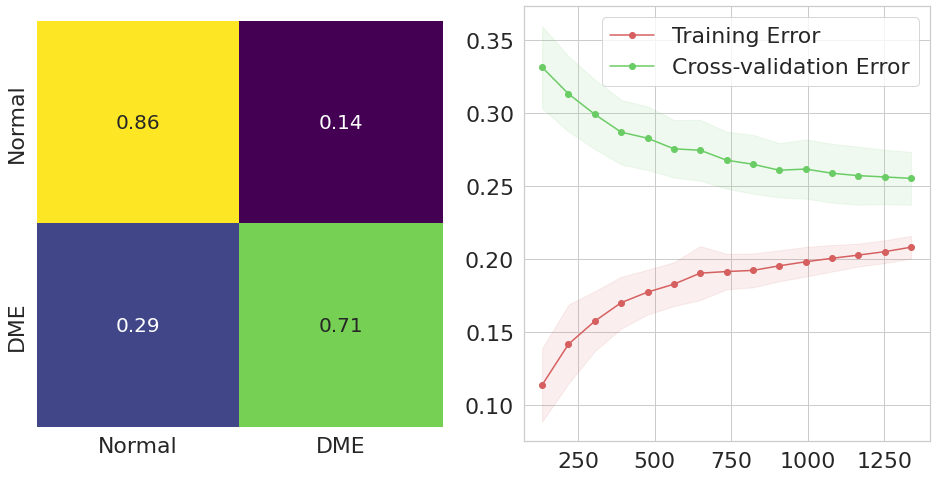

In [173]:
model = XGBClassifier(learning_rate=0.01, max_depth=5, random_state=0, verbosity=1)
model,Summary_XGB = PrintResults(model, x_train, y_train, 'XGB')
y_train_XGB= pd.Series(model.predict(x_train), name = "XGB")
y_test_XGB = pd.Series(model.predict(x_test), name = "XGB")

# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

In [174]:
# best Model 
Class_Results = pd.concat([Summary_LR, Summary_SGD, Summary_RF, 
                           Summary_SVM, Summary_KNN, Summary_GNB,
                           Summary_MLP, Summary_LSVM, Summary_DT,
                           Summary_XGB], ignore_index = True)
    

Class_Results = Class_Results.sort_values(by = 'Accuracy', ascending=False)
Class_Results = Class_Results.set_index('Accuracy')
Class_Results.head(10)

,Model,Score Mean,Score St Dv,Precision,Recall,F1-Score
Accuracy,,,,,,
75.0,Random Forest,97.478447,0.615909,97.777778,97.777778,97.777778
74.0,XGB,81.816861,1.439465,85.152284,71.005291,77.437969
72.0,DT,99.241881,0.270481,98.437500,100.000000,99.212598
71.0,KNN,82.772070,1.447125,86.504425,82.751323,84.586263
65.0,SVM,63.244956,2.047172,80.692168,46.878307,59.303882
59.0,LSVM,59.047780,2.671860,60.710855,66.878307,63.645519
58.0,Logistic Regression,57.288343,2.656544,59.061033,66.560847,62.587065
58.0,GNB,60.880775,3.424252,86.617100,24.656085,38.385502
55.0,SGD,55.428344,4.192758,78.378378,27.619048,40.845070


All the models have trained with normalized features and without selecting best features so far. Let's look into the best features in highest accurate model

Scoring Accuracy: 75.00 %
Scoring Mean: 84.40 %
Scoring Standard Deviation: 1.1806 %
Precision: 85.82 %
Recall: 74.92 %
f1-score: 80.00 %


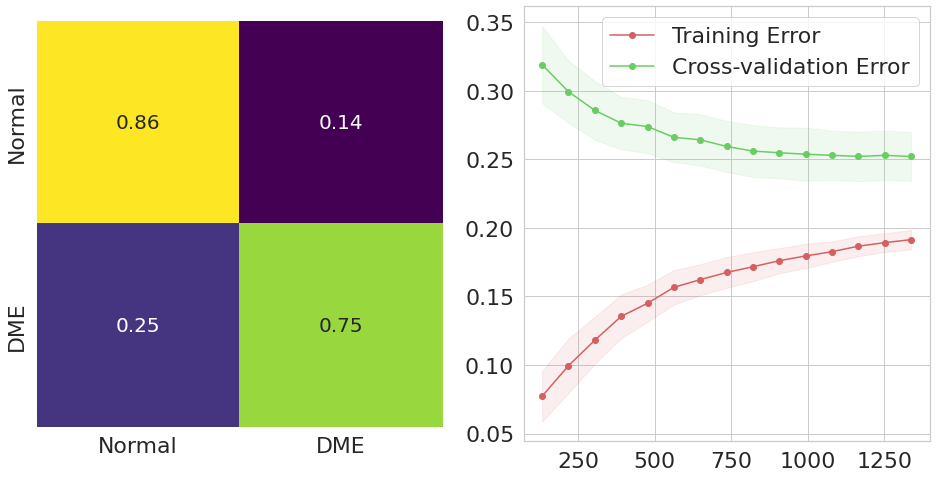

In [187]:
# model_rf_final = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'entropy',
#             max_depth = 10, max_features = 'log2', max_leaf_nodes = None,
#             min_impurity_decrease = 0.0,
#             min_samples_leaf = 1, min_samples_split = 30,
#             min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = 1,
#             oob_score = False, random_state = None, verbose = 0, warm_start = False)

# model = XGBClassifier(learning_rate=0.1, max_depth=3, random_state=0, verbosity=1)
# eval_set = [(x_train, y_train), (x_test, y_test)]
# model.fit(x_train, y_train, eval_metric=[ "logloss", "error"], eval_set=eval_set, verbose=False)


# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


model_rf_final = XGBClassifier(
    learning_rate =0.01, n_estimators=200,max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27, 
    random_state=0, verbosity=1)

_, Summary_LR = PrintResults(model_rf_final, x_train, y_train, 'XGB_final')
y_train_pred = pd.Series(model_rf_final.predict(x_train), name = 'Normal')
y_test_pred = pd.Series(model_rf_final.predict(x_test), name = "Normal")

In [188]:
importance = model_rf_final.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
print(np.argsort(importance),np.sort(importance))

Feature: 0, Score: 0.10138
Feature: 1, Score: 0.19109
Feature: 2, Score: 0.08189
Feature: 3, Score: 0.12094
Feature: 4, Score: 0.07886
Feature: 5, Score: 0.05033
Feature: 6, Score: 0.12124
Feature: 7, Score: 0.08044
Feature: 8, Score: 0.05838
Feature: 9, Score: 0.06832
Feature: 10, Score: 0.04713
[10  5  8  9  4  7  2  0  3  6  1] [0.04713038 0.05033352 0.05837574 0.06831976 0.07885626 0.08043768
 0.08188898 0.10138357 0.12094231 0.12123952 0.1910923 ]


In [189]:
best_features_xg = np.argsort(importance)[6:]
best_features_xg

array([2, 0, 3, 6, 1])

In [207]:
X = new_df[best_features_xg]
y = new_df["target"]
X.shape, y.shape

((2229, 5), (2229,))

Scoring Accuracy: 52.00 %
Scoring Mean: 76.95 %
Scoring Standard Deviation: 1.6614 %
Precision: 64.28 %
Recall: 94.24 %
f1-score: 76.43 %


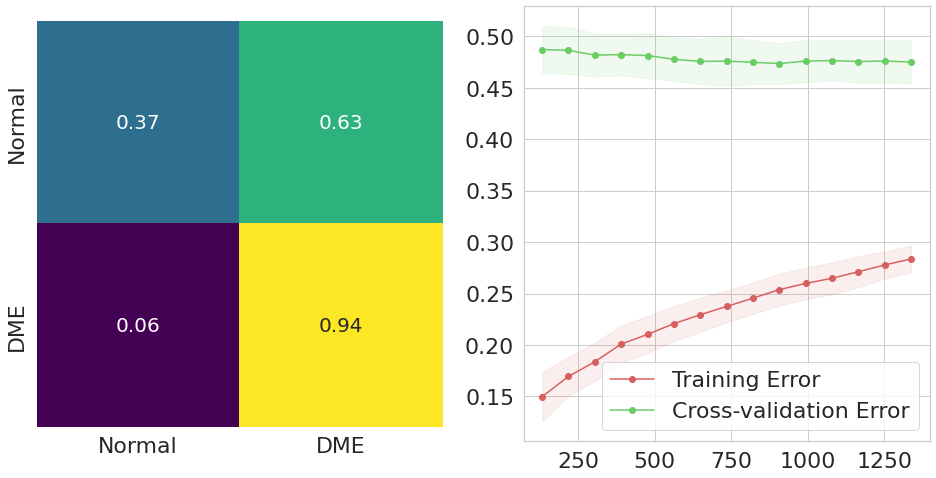

In [208]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

new_model = XGBClassifier(
    learning_rate =0.01, n_estimators=200,max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27, 
    random_state=0, verbosity=1)

_, Summary_LR = PrintResults(new_model, x_train, y_train, 'RF')
y_train_pred = pd.Series(new_model.predict(x_train), name = 'Normal')
y_test_pred = pd.Series(new_model.predict(x_test), name = "Normal")

In [216]:
X = new_df.iloc[:,0:11]
y = new_df["target"]
X.shape, y.shape

((2229, 11), (2229,))

In [218]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(11,'Score')  
selected_features = list(featureScores.sort_values(by =["Score"], ascending=False)[:5]['Specs'])
selected_features

[10, 7, 9, 6, 8]

(2229, 5) (2229,)
Scoring Accuracy: 53.00 %
Scoring Mean: 80.18 %
Scoring Standard Deviation: 1.8763 %
Precision: 65.49 %
Recall: 93.52 %
f1-score: 77.03 %


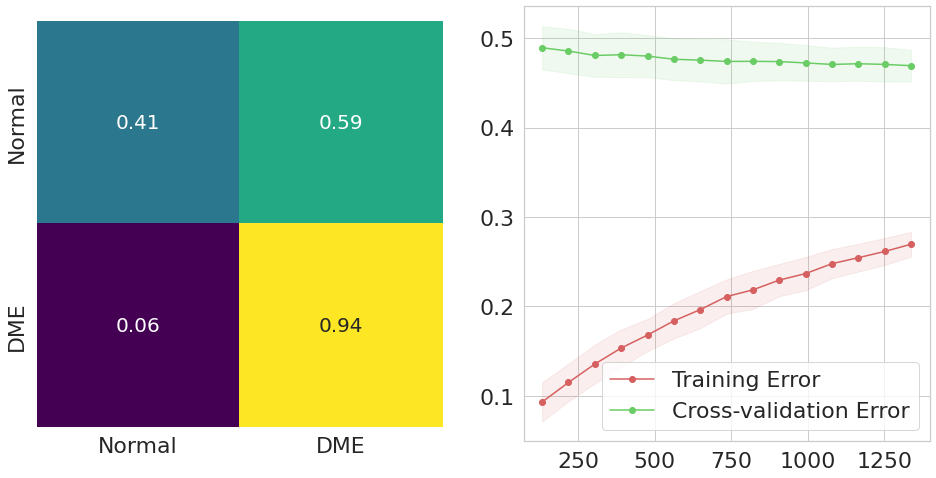

In [219]:
X = new_df[selected_features]
y = new_df["target"]
print(X.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

new_model = XGBClassifier(
    learning_rate =0.01, n_estimators=200,max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27, 
    random_state=0, verbosity=1)

_, Summary_LR = PrintResults(new_model, x_train, y_train, 'RF')
y_train_pred = pd.Series(new_model.predict(x_train), name = 'Normal')
y_test_pred = pd.Series(new_model.predict(x_test), name = "Normal")

In [ ]:
def plot_conf_matrix(predict_test, y_test, predict_val, y_val):
  cm = confusion_matrix(predict_test, y_test)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix for test')

  cm = confusion_matrix(predict_val, y_val)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix for val')

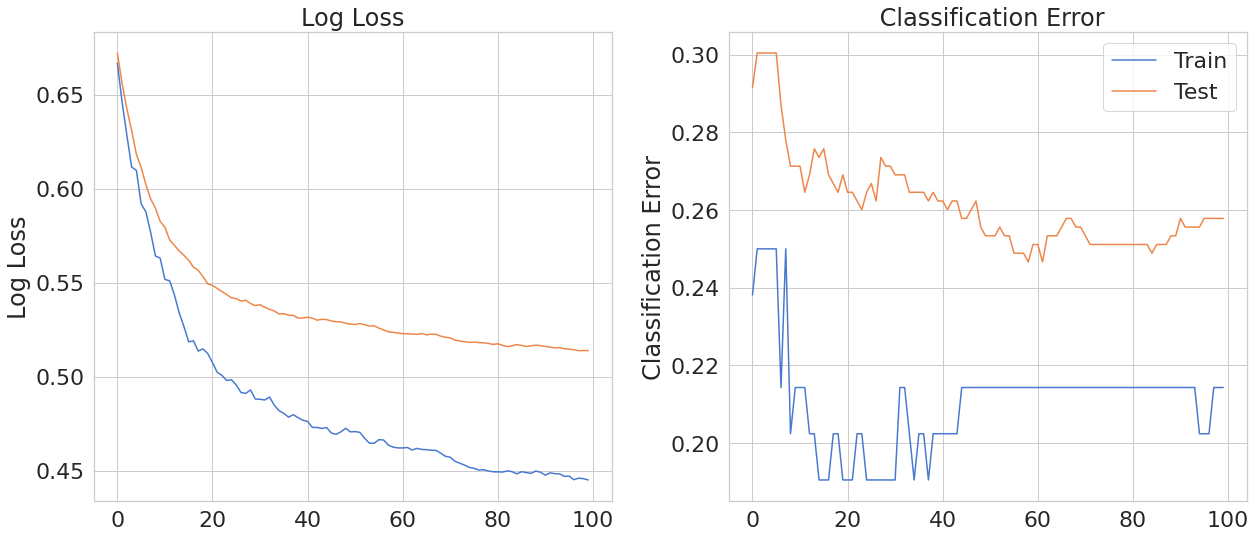

In [ ]:
eval_set = [(x_val, y_val), (x_test, y_test)]
# eval_set = [(x_train, y_train), (x_test, y_test)]
model = XGBClassifier(learning_rate=0.1, max_depth=3, random_state=0, verbosity=1)
model.fit(x_train, y_train, eval_metric=[ "logloss", "error"], eval_set=eval_set, verbose=False)

results = model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results["validation_0"]["logloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["logloss"], label="Test")
plt.ylabel("Log Loss")
plt.title("Log Loss")


plt.subplot(1, 2, 2)
plt.plot(x_axis, results["validation_0"]["error"], label="Train")
plt.plot(x_axis, results["validation_1"]["error"], label="Test")
plt.legend()
plt.ylabel("Classification Error")
plt.title(" Classification Error")
plt.tight_layout()
plt.show()